## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [234]:
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
h,  w = gray.shape
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

cv2.destroyAllWindows()

In [235]:
#Debug vriables for testing test images
saveImages = True
filename = ""

#Polynomia fit of lane lines
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

#Polynomials of previous frame
previous_left_fit = np.copy(left_fit)
previous_right_fit = np.copy(right_fit)

#Coefficient to scale current polyfit with previous polyfit.
alpha = 0.075

#Curvature and veh pos offset.
left_curverad = 0
right_curverad = 0
veh_pos_from_centre = 0

In [236]:
def getLaneColoredImage(warpedImg):
    global left_fit
    global right_fit

    y_range = np.arange(0, warpedImg.shape[0])
    #Find the range of pixels in x axis for both lane polynomials and fill the region between them in Green
    x_range = left_fit[0] * y_range**2 + left_fit[1] * y_range + left_fit[2]
    #Clip if output of polyFit is out of range.
    x_range[x_range < 0] = 0
    x_range[x_range >= warpedImg.shape[1]] = warpedImg.shape[1] - 1
    #Convert points to a format acceptable by np.polyfit
    pts_left = np.array([np.transpose(np.vstack([x_range, y_range]))])

    #Repeat the same for right lane
    x_range = right_fit[0] * y_range**2 + right_fit[1] * y_range + right_fit[2]
    x_range[x_range < 0] = 0
    x_range[x_range >= warpedImg.shape[1]] = warpedImg.shape[1] - 1

    pts_right = np.array([np.flipud(np.transpose(np.vstack([x_range, y_range])))])
    pts = np.hstack((pts_left, pts_right))

    #Image with polyfit
    polyImg = np.zeros_like(warpedImg)
    #Convert image to 3Chl
    polyImg3Chl = cv2.merge((polyImg, polyImg, polyImg))

    cv2.fillPoly(polyImg3Chl, np.int_([pts]), (0, 255, 0))
    
    return polyImg3Chl

In [237]:
def findCurvatureAndVehPos(fitImg):
    global left_fit
    global right_fit

    global left_curverad
    global right_curverad
    global veh_pos_from_centre

    #Range of pixels along the image row
    y_range = np.arange(0, fitImg.shape[0] + 1)
    #Coefficient for transforming units
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension
    #Curvature
    left_curverad = ((1 + (2*left_fit[0]*np.max(y_range)*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*np.max(y_range)*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # compute the offset from the center
    left_lane_intercept = left_fit[0] * y_range[fitImg.shape[0]-1]**2 + left_fit[1] * y_range[fitImg.shape[0]-1] + left_fit[2]
    right_lane_intercept = right_fit[0] * y_range[fitImg.shape[0]-1]**2 + right_fit[1] * y_range[fitImg.shape[0]-1] + right_fit[2]
    
    lane_center = (left_lane_intercept + right_lane_intercept)/2

    veh_pos_from_centre = abs(fitImg.shape[1]/2 - lane_center)
    veh_pos_from_centre = xm_per_pix*veh_pos_from_centre

In [238]:
def fitPolyToLaneLines(warpedImg, left_lane_idx, left_lane_valid, right_lane_idx, right_lane_valid):
    global left_fit
    global right_fit

    #Apply sliding windows for each lane lines.
    total_window_count = 15 #Total windows per lane line
    window_height = int(warpedImg.shape[0]/total_window_count) #Height of each window.
    window_margin = 70
    
    #Both these arrays will contain the x index of the left-most part of each window
    left_windows = np.zeros(int(warpedImg.shape[0]/window_height))
    right_windows = np.zeros(int(warpedImg.shape[0]/window_height))

    #First window x -coordinate is the lane line idexes
    left_windows = np.insert(left_windows, 0, int(left_lane_idx - int(window_margin/2)))
    right_windows = np.insert(right_windows, 0, int(right_lane_idx - int(window_margin/2)))
    #Each successive window scans the pixels in the region of [prev_window - margin : prev_window + margin].
    #Threshold is the step for window movement in each iteration.
    threshold = 10
    
    #Iterate through each windows and set each window to a position which has maximum intensity of pixels under it.
    for window_count in range(0, total_window_count+1):
        if left_lane_valid == True:
            #max_pixel_count is the maximum of the sum of pixels occupied by the window
            max_pixel_count = 0
            #Window index of the previous iwndow
            if window_count != 0:
                window_index = window_count - 1
            else:
                window_index = 0
            #chosen_window x - coordinate
            chosen_window_test = left_windows[window_index]
            #Iterate from (prev_window - margin) to (prev_window + margin) in steps of threshold
            for window_test in range(int(left_windows[window_index] - window_margin) , int(left_windows[window_index] +  window_margin), threshold):
                #Choose the coordinate for the window for which the intensity underneath is maximum.
                if np.sum(warpedImg[int((total_window_count - window_count)*window_height) - int(window_height) : int((total_window_count - window_count)*window_height), window_test:window_test+window_margin]) > max_pixel_count:
                    max_pixel_count = np.sum(warpedImg[int((total_window_count - window_count)*window_height) - int(window_height) : int((total_window_count - window_count)*window_height), window_test:window_test+window_margin])
                    chosen_window_test = window_test
            #Add the index to the window array. Index is that of the previous window if intensity underneath is 0
            left_windows = np.insert(left_windows, window_count, chosen_window_test)

        #Repeat the same for right lane
        if right_lane_valid == True:
            max_pixel_count = 0
            if window_count != 0:
                window_index = window_count - 1
            else:
                window_index = 0
            chosen_window_test = right_windows[window_index]
            for window_test in range(int(right_windows[window_index] - window_margin) , int(right_windows[window_index] +  window_margin), threshold):
                if np.sum(warpedImg[int((total_window_count - window_count)*window_height) - int(window_height) : int((total_window_count - window_count)*window_height), window_test:window_test+window_margin]) > max_pixel_count:
                    max_pixel_count = np.sum(warpedImg[int((total_window_count - window_count)*window_height) - int(window_height) : int((total_window_count - window_count)*window_height), window_test:window_test+window_margin])
                    chosen_window_test = window_test
            right_windows = np.insert(right_windows, window_count, chosen_window_test)
    
    #All the non_zero pixels in the image.
    non_zero_x = np.array(warpedImg.nonzero()[1])
    non_zero_y = np.array(warpedImg.nonzero()[0])
    
    #x and y coordinates of all the pixels of left lane line occupied under the window.
    left_marker_x = []
    left_marker_y = []

    right_marker_x = []
    right_marker_y = []

    window_img = np.copy(warpedImg)
    for window in range(0, total_window_count):
        if left_lane_valid == True:
            #Color the region under the window for window image.
            window_img[int((total_window_count - window)*window_height) - int(window_height) : int((total_window_count - window)*window_height), int(left_windows[window]):int(left_windows[window]+window_margin)] = 100
            #Region mask within the window
            mask = np.logical_and(np.logical_and(np.logical_and((non_zero_x > int(left_windows[window])) , (non_zero_x < int(left_windows[window]+window_margin))) , (non_zero_y > int((total_window_count - window)*window_height) - int(window_height))) , (non_zero_y < int((total_window_count - window)*window_height)))
            #All non zero pixels under the window
            left_marker_x.extend(non_zero_x[mask])
            left_marker_y.extend(non_zero_y[mask])
        #Repeat the same for right lane line
        if right_lane_valid == True:
            window_img[int((total_window_count - window)*window_height) - int(window_height) : int((total_window_count - window)*window_height), int(right_windows[window]):int(right_windows[window]+window_margin)] = 100
            mask = np.logical_and(np.logical_and(np.logical_and((non_zero_x > int(right_windows[window])) , (non_zero_x < int(right_windows[window]+window_margin))) , (non_zero_y > int((total_window_count - window)*window_height) - int(window_height))) , (non_zero_y < int((total_window_count - window)*window_height)))
            right_marker_x.extend(non_zero_x[mask])
            right_marker_y.extend(non_zero_y[mask])

    #Overlap the windowImg with the warped image.
    #warped3Chl = cv2.cvtColor(warpedImg, cv2.COLOR_GRAY2BGR)
    #windowOverlap = cv2.addWeighted(warped3Chl, 0.5, window_img, 1, 0)
    
    if left_lane_valid == True:
        #Convert to a format acceptable by np.polyfit
        left_marker_x = np.asarray(left_marker_x, dtype=np.int32)
        left_marker_y = np.asarray(left_marker_y, dtype=np.int32)
        #Fit the lane lines with polynomial of degree 2 and save it to global.
        left_fit = np.polyfit(left_marker_y, left_marker_x, 2)
        
    #Repeat the same for right lane.
    if right_lane_valid == True:
        right_marker_x = np.asarray(right_marker_x, dtype=np.int32)
        right_marker_y = np.asarray(right_marker_y, dtype=np.int32)

        right_fit = np.polyfit(right_marker_y, right_marker_x, 2)

In [239]:
def getLaneIdxAndValidity(warpedImg):
    #Following boolean is to indicate if the lane markers have enough pixels to be identified as such.
    left_lane_valid = True
    right_lane_valid = True
    #Find the histogram as sum of all pixels in a row for each column
    histogram = np.zeros(warpedImg.shape[1])
    for column in range(0, len(warpedImg[0,:])):
        histogram[column] = np.sum(warpedImg[:,column])
    #left and right lane indexes are maximum indexes of left half and right half of the image.
    left_lane_idx = np.argmax(np.array_split(histogram, 2)[0])

    right_lane_idx = np.argmax(np.array_split(histogram, 2)[1]) + int(len(histogram)/2)

    #If sum of pixels at lane indexes is less than a threshold, then ignore the lane pixel.
    if histogram[left_lane_idx] < 5000:
        left_lane_valid = False
    if histogram[right_lane_idx] < 5000:
        right_lane_valid = False
    #Return lane idx and validity.
    return left_lane_idx, left_lane_valid, right_lane_idx, right_lane_valid

In [240]:
def getwarpedImg(threshold_img, src, dst):
    #Get the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #Get the warped image.
    warpedImg = cv2.warpPerspective(threshold_img, M, (threshold_img.shape[1],threshold_img.shape[0]), flags=cv2.INTER_LINEAR)
    #Return the warped image.
    return warpedImg

In [241]:
def performBinaryThreshold(undistImg):
    #Convert image to HLS space and extract saturation iamge.
    hlsImg = cv2.cvtColor(undistImg, cv2.COLOR_BGR2HLS)
    satImg = hlsImg[:,:,2]

    if saveImages == True:
        plt.imshow(satImg)
        plt.show()

    #transform to gray scale
    gray = cv2.cvtColor(undistImg, cv2.COLOR_RGB2GRAY)

    #Find sobel magnitude image by applying sobel_x and sobel_y with kernel = 3
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    abs_grad_x = abs(grad_x)
    scaledImgX = np.uint8(255*abs_grad_x/np.max(abs_grad_x))
        #sobel_y
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 2, ksize=3)
    abs_grad_y = abs(grad_y)
    scaledImgY = np.uint8(255*abs_grad_y/np.max(abs_grad_y))
        #Magnitude from sobel_x and sobel_y
    magImg = np.sqrt(scaledImgX**2 + scaledImgY**2)
    scale_factor = np.max(magImg)/255
    magImg = (magImg/scale_factor).astype(np.uint8)

    if saveImages == True:
        plt.imshow(magImg)
        plt.show()
    
    #Combine both the saturation image and magnitude image by applying an arbitrary threshold seperately for each
    combined_img = np.zeros_like(scaledImgX)
    combined_img[np.logical_and(satImg > 150, magImg > 70)] = 255
    #Return the combined image.
    return combined_img

In [242]:
def scalePolyFit():
    global left_fit
    global right_fit
    global previous_left_fit
    global previous_right_fit
    
    #Scale polyFit to be closer to previousfit to avoid flickering and major deviations
    left_fit = previous_left_fit + alpha * (left_fit - previous_left_fit)
    right_fit = previous_right_fit + alpha * (right_fit - previous_right_fit)
    
    #Store current polyFit to previous polyFit
    previous_left_fit = np.copy(left_fit)
    previous_right_fit = np.copy(right_fit)

In [243]:
def pipeline(img):

    #undistort the image first.
    undistImg = cv2.undistort(img, mtx, dist, None, mtx)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    if saveImages == True:
        cv2.imshow('undistImg',img)
        plt.show()

    #Perform binary thresholding on the undistorted image
    threshold_img = performBinaryThreshold(undistImg)

    if saveImages == True:
        plt.imshow(threshold_img)
        plt.show()
    
    #Choose an arbitrary four points in the source image for perspective transform
    top_right = (725, 455)
    top_left = (555, 455)
    botom_right = (1280, 680)
    botom_left = (0, 680)

    #Fix a vertice with the points aligning with the lane boundaries
    src = np.float32([[botom_left],[top_left],[top_right],[botom_right]])

    #Set destination points to be the image boundaries.
    dst = np.float32([[0, undistImg.shape[0]],[0, 0],[undistImg.shape[1], 0],[undistImg.shape[1], undistImg.shape[0]]])
    warpedImg = getwarpedImg(threshold_img, src, dst)

    if saveImages == True:
        plt.imshow(warpedImg)
        plt.show()

    #Perform histogram analysis and find both lane indexes in the image. (This is done on binary thresholded image)
    left_lane_idx, left_lane_valid, right_lane_idx, right_lane_valid = getLaneIdxAndValidity(warpedImg)

    #Find Poly Fit and color the region between the lanes.
    fitPolyToLaneLines(warpedImg, left_lane_idx, left_lane_valid, right_lane_idx, right_lane_valid)
    
    if saveImages == False:
    #Scale polyFit by making it closer to previous polyfit. Do it only for the video as using previous polyfit for images doesn't make sense.
        scalePolyFit()
    
    #Color region between lane lines
    polyFit = getLaneColoredImage(warpedImg)
    
    if saveImages == True:
        plt.imshow(polyFit)
        plt.show()

    #Compute curvate and veh pos from centre.
    findCurvatureAndVehPos(polyFit)

    #Apply the inverse warp transform to fit lane regions in source image
    markedLanes = getwarpedImg(polyFit, dst, src)

    if saveImages == True:
        plt.imshow(markedLanes)
        plt.show()

    #Overlap source image and lane marked image.
    overLappedImg = cv2.addWeighted(img, 1, markedLanes, 0.5, 0)

    if saveImages == True:
        plt.imshow(overLappedImg)
        plt.show()

    #Write curvature and veh pos offset on the image.
    curvature = "Left Radius of curvature: %.2f m" % left_curverad
    cv2.putText(overLappedImg, curvature , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    curvature = "Right Radius of curvature: %.2f m" % right_curverad
    cv2.putText(overLappedImg,  curvature, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    curvature = "Veh Position From Centre: %.2f m" % veh_pos_from_centre
    cv2.putText(overLappedImg,  curvature, (100, 210), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    if saveImages == True:
        output =  filename.replace("test_images", "output_images")
        cv2.imwrite(output.replace(".jpg", "_undistorted.jpg"), undistImg)
        
        output =  filename.replace("test_images", "output_images")
        cv2.imwrite(output.replace(".jpg", "_thresholded_binary.jpg"), threshold_img)
        
        output =  filename.replace("test_images", "output_images")
        cv2.imwrite(output.replace(".jpg", "_perspective_transformed.jpg"), warpedImg)
        
        output =  filename.replace("test_images", "output_images")
        cv2.imwrite(output.replace(".jpg", "_final_overlapped.jpg"), overLappedImg)
    return overLappedImg

## Read the list of test images

In [244]:
saveImages = False
#Create video file pipeline
output = '../project_video_output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
saveImages = True

t:   0%|                                                                    | 2/1260 [00:00<01:27, 14.32it/s, now=None]

Moviepy - Building video ../project_video_output.mp4.
Moviepy - Writing video ../project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ../project_video_output.mp4
Wall time: 3min 2s


In [245]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

../test_images\test1.jpg


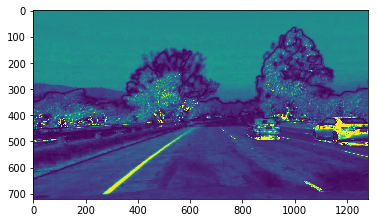

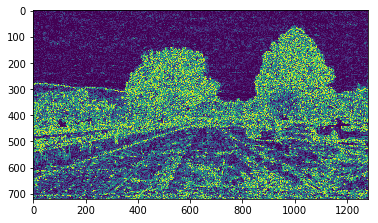

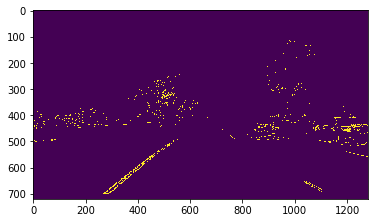

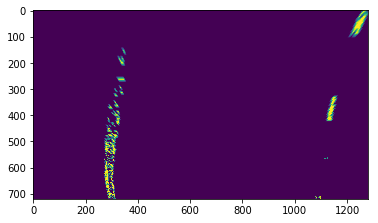

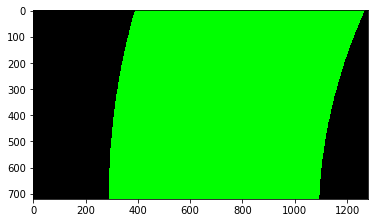

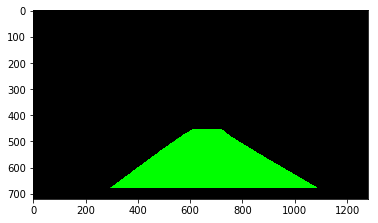

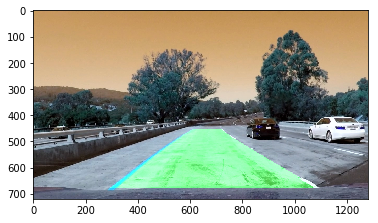

../test_images\test2.jpg


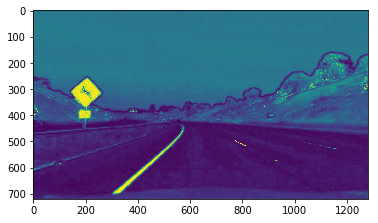

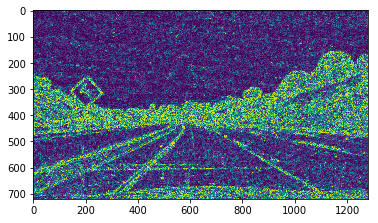

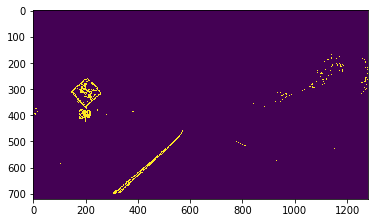

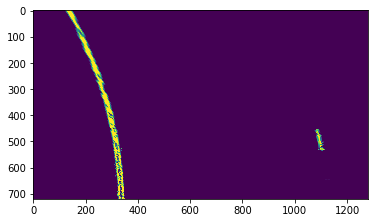

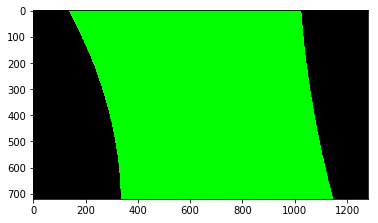

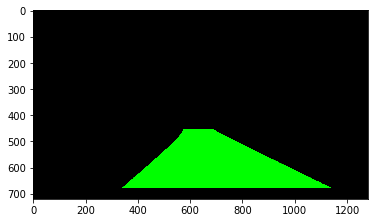

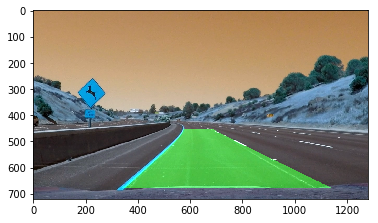

../test_images\test3.jpg


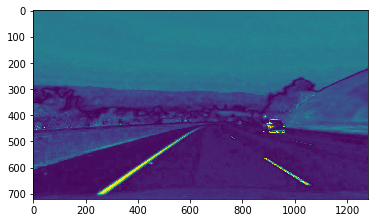

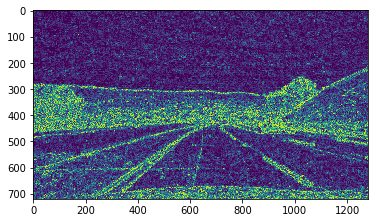

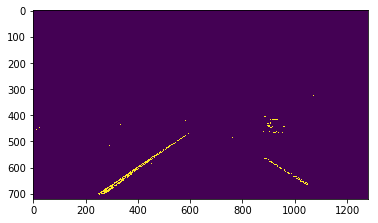

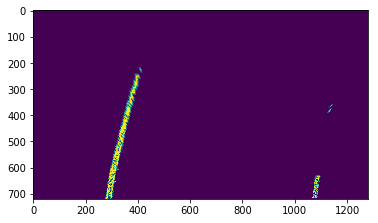

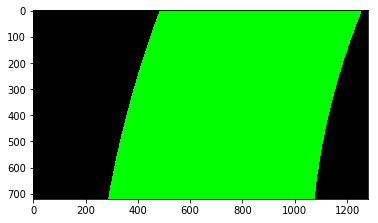

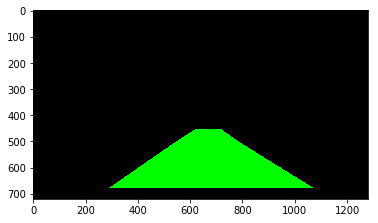

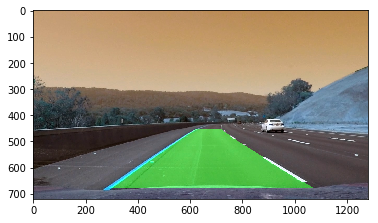

../test_images\test4.jpg


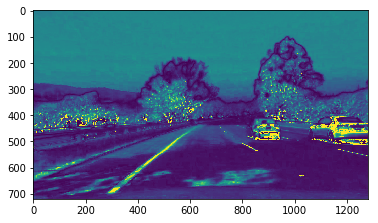

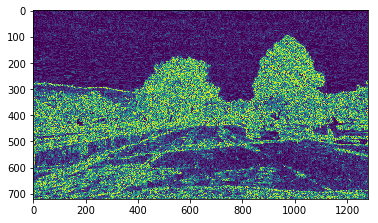

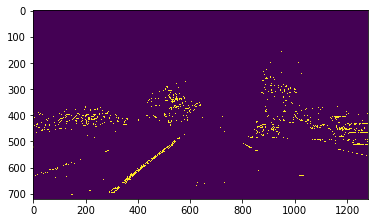

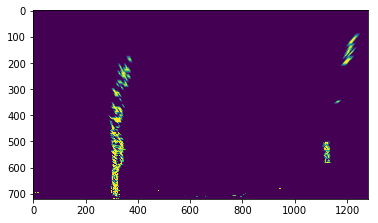

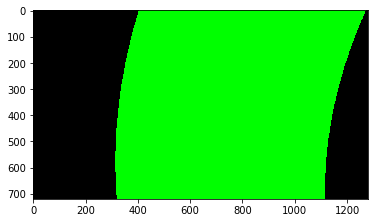

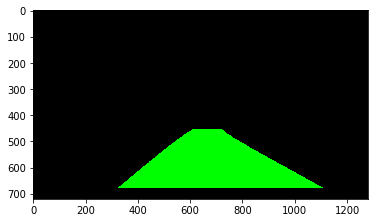

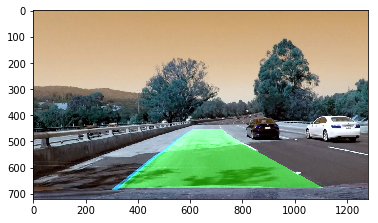

../test_images\test5.jpg


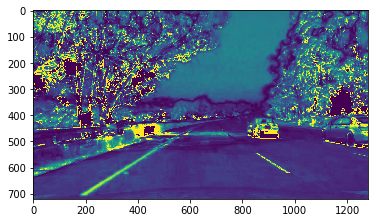

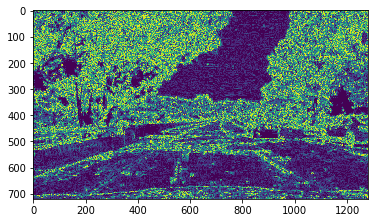

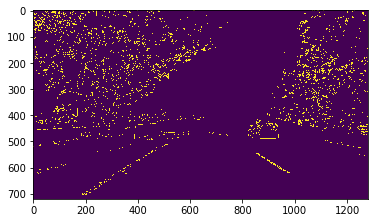

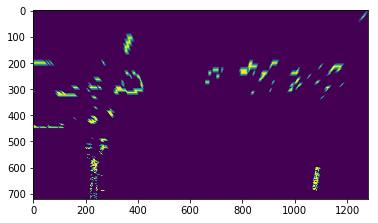

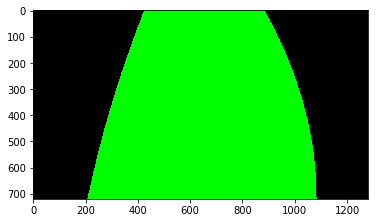

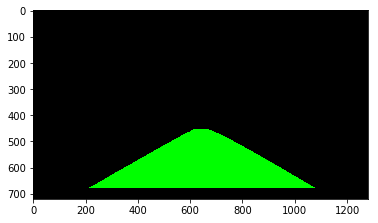

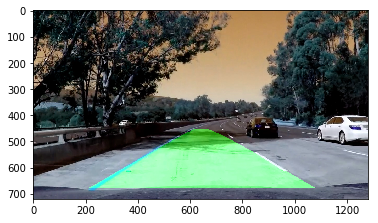

../test_images\test6.jpg


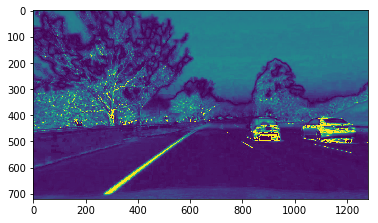

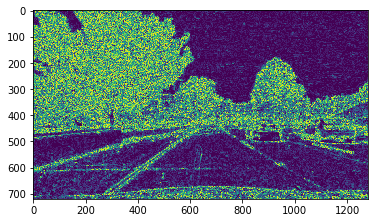

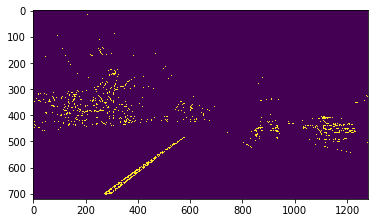

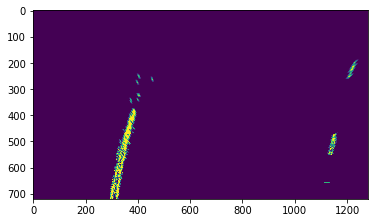

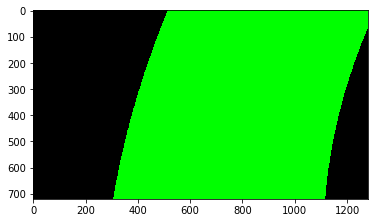

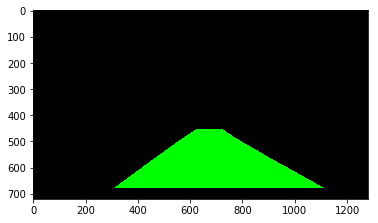

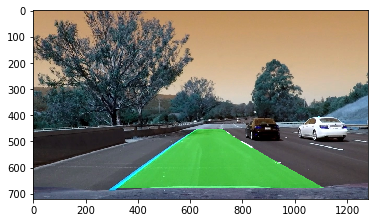

../test_images\straight_lines1.jpg


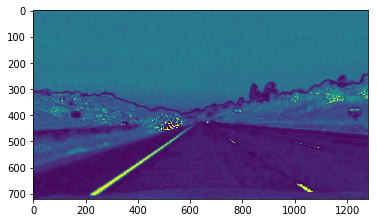

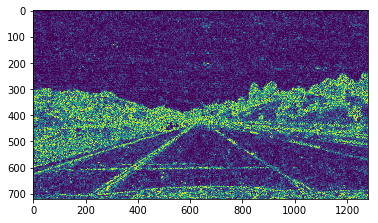

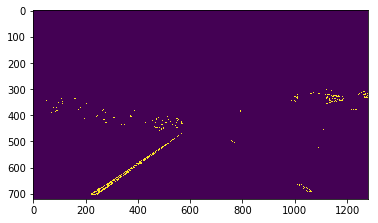

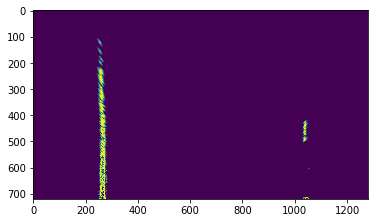

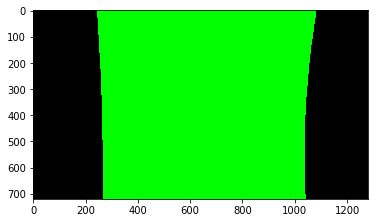

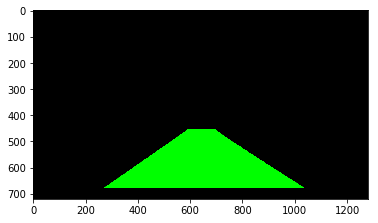

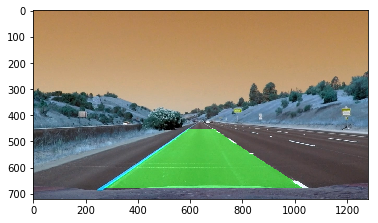

../test_images\straight_lines2.jpg


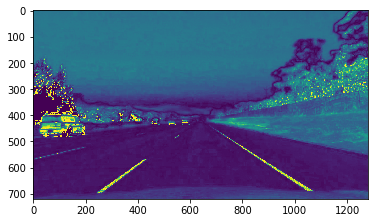

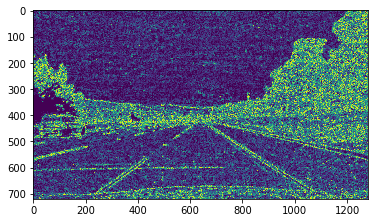

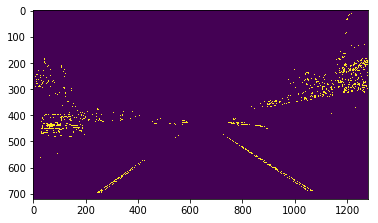

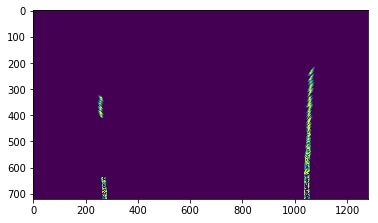

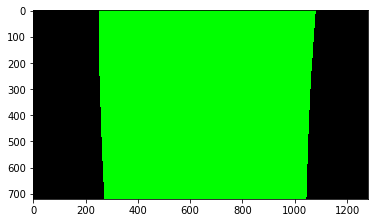

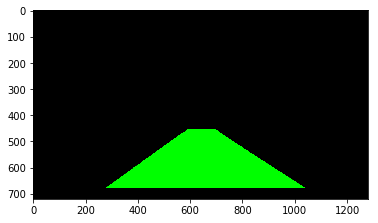

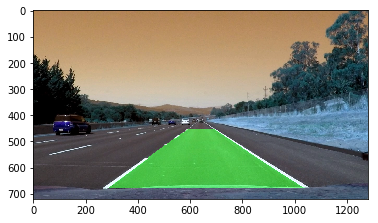

In [196]:
# Test block to test pipeline on test images.
images = glob.glob('../test_images/test*.jpg')

images.extend(glob.glob('../test_images/straight_lines*.jpg'))

for fname in images:
    print (fname)
    filename = fname
    img = cv2.imread(fname)

    finalImg = pipeline(img)
    
    #cv2.imshow('finalImg', finalImg)
    #cv2.waitKey(5000)